In [93]:
# Imports
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import shutil
import random
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from keras import layers, models, optimizers

# 0. EDA and File Management
# b) Read in 10 random images, plot and extract their labels and print them in the title.

In [61]:
paths = {
    # Paths to the original training and testing data
    "original_train_data": "original_data/train/train",
    "original_test_data": "original_data/test/test",
    # Path to experiment_small_data and experiment_tiny_data
    "experiment_small_dir": "experiment_small_data", 
    "experiment_tiny_dir": "experiment_tiny_data",
    # Path to experiment_small_data subdirs: Test,Train,Val
    "experiment_small_test": "experiment_small_data/test",
    "experiment_small_train": "experiment_small_data/train",
    "experiment_small_val": "experiment_small_data/val",
    # Path to experiment_tiny_data subdirs: Test,Train,Val
    "experiment_tiny_test": "experiment_tiny_data/test",
    "experiment_tiny_train": "experiment_tiny_data/train",
    "experiment_tiny_val": "experiment_tiny_data/val"
}

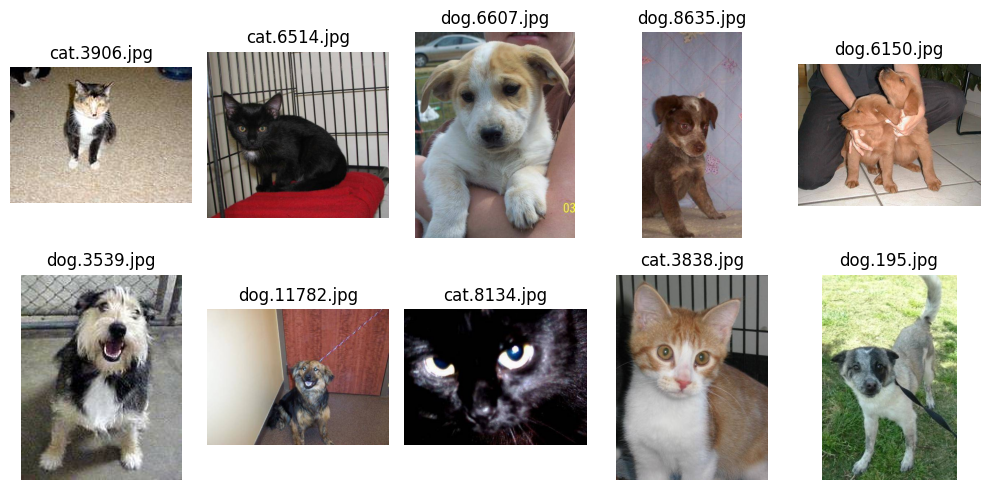

In [62]:
# Function to load 10 random images
def load_10_random_images(directory, num_images=10):
    image_files = os.listdir(directory)
    random_indices = np.random.choice(len(image_files), num_images, replace=False)
    random_images = [(Image.open(os.path.join(directory, image_files[i])), image_files[i]) for i in random_indices]
    return random_images

# Directory for the training data that includes all images of cats or dogs
image_dir = paths["original_train_data"]

images_with_labels = load_10_random_images(image_dir)

# Plot pictures with their label as a title for each picture
plt.figure(figsize=(10, 5))
for i, (image, label) in enumerate(images_with_labels):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(f"{label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# C) Creating the folder structure

In [63]:
# Function for creating the main folder structure
# The original_data folder is manually renamed with all the data downloaded and extracted from: https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats
def create_folder_structure():
    folders = ['experiment_small_data', 'experiment_tiny_data']
    subfolders = ['test', 'train', 'val']

    for f in folders:
        os.makedirs(f, exist_ok=True)
        for sf in subfolders:
            os.makedirs(os.path.join(f, sf), exist_ok=True)

# Call the function
create_folder_structure()

# D) Clear subfolder directories within experiment folders and train|val|test splits

In [64]:
# Collect all images from train and test directories
train_images = os.listdir(paths["original_train_data"])
test_images = os.listdir(paths["original_test_data"]) 

# Separate dogs and cats in the training data based on filenames
dog_images = [img for img in train_images if 'dog' in img] 
cat_images = [img for img in train_images if 'cat' in img]

# Function to clear directories to avoid exceeding the desired amount of images when calling the function to create the splits
def clear_directory(directory):
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        if os.path.isfile(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)

# Function for copying files to subfolders within experiment folders.
def copy_files(file_list, destination, source_dir):
    for file in file_list:
        src = os.path.join(source_dir, file)
        dest = os.path.join(destination, file)
        shutil.copy(src, dest)

def create_splits(dog_images, cat_images, test_images, train_size, val_size, test_size, output_path):
    random.shuffle(dog_images)
    random.shuffle(cat_images)
    random.shuffle(test_images)

    train_dir = os.path.join(output_path, 'train')
    val_dir = os.path.join(output_path, 'val')
    test_dir = os.path.join(output_path, 'test')
     
    # Clear the destination directories
    clear_directory(train_dir)
    clear_directory(val_dir)
    clear_directory(test_dir)

    # Calculation for train,val,test to get the right amount
    train_dogs = dog_images[:train_size // 2] 
    train_cats = cat_images[:train_size // 2] 
    val_dogs = dog_images[train_size // 2:train_size // 2 + val_size // 2] 
    val_cats = cat_images[train_size // 2:train_size // 2 + val_size // 2] 
    test_subset = test_images[:test_size] 

    copy_files(train_dogs, train_dir, paths["original_train_data"]) # Dogs training images
    copy_files(train_cats, train_dir, paths["original_train_data"]) # Cats training images
    copy_files(val_dogs, val_dir, paths["original_train_data"]) # Dogs val images
    copy_files(val_cats, val_dir, paths["original_train_data"]) # Cats val images
    copy_files(test_subset, test_dir, paths["original_test_data"]) # Testing images 

create_splits(dog_images, cat_images, test_images, 1600, 400, 500, paths["experiment_small_dir"]) # train, val, test (1600, 400, 500)
create_splits(dog_images, cat_images, test_images, 160, 40, 50, paths["experiment_tiny_dir"]) # train, val, test (160, 40, 50)

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'experiment_small_data\\test\\10.jpg'

# E) Process data in order of first loading images, extract labels, encode labels and one-hot encode labels

In [ ]:
small_train_dir = paths["experiment_small_train"] # small training images
tiny_train_dir = paths["experiment_tiny_train"] # tiny training images
small_val_dir = paths["experiment_small_val"] # small val images
tiny_val_dir = paths["experiment_tiny_val"] # tiny val images

# Function to load images from file paths
def load_images(image_dir):
    images = []
    for filename in os.listdir(image_dir):
        # Load each image 
        image_path = os.path.join(image_dir, filename)
        try:
            image = Image.open(image_path)
            images.append(image)
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
    return images

# Function to extract labels from images
def extract_labels(image_dir):
    labels = []
    for filename in os.listdir(image_dir):
        if 'dog' in filename:
            labels.append('dog')
        elif 'cat' in filename:
            labels.append('cat')
    return labels

# Function to encode the extracted labels
def encode_labels(labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    return encoded_labels

# Function to one-hot encode the numeric labels
def one_hot_encode(labels):
    onehot_encoder = OneHotEncoder(sparse_output=False)
    labels = np.array(labels).reshape(-1, 1)
    onehot_labels = onehot_encoder.fit_transform(labels)
    return onehot_labels

# Function to process image data by extracting, encoding, and one-hot encoding labels
def process_data(image_dir): 
    # Load images from the specified directory
    loading_images = load_images(image_dir)
    # Extract labels for both training and validation images
    labels = extract_labels(image_dir)
    # Encode the extracted labels
    encoded_labels = encode_labels(labels)
    # One-hot encode the numeric labels
    onehot_labels = one_hot_encode(encoded_labels)
    # Return loaded images, labels, encoded labels, and one-hot encoded labels
    return loading_images, labels, encoded_labels, onehot_labels # The returned values: 1 represents 'dog', 0 represents 'cat'

# Read image data from the small and tiny experiment subfolders and process it to obtain labels, encoded labels, and one-hot labels.
small_train_images, small_train_labels, encoded_small_train_labels, onehot_small_train_labels = process_data(small_train_dir)
tiny_train_images, tiny_train_labels, encoded_tiny_train_labels, onehot_tiny_train_labels = process_data(tiny_train_dir)
small_val_images, small_val_labels, encoded_small_val_labels, onehot_small_val_labels = process_data(small_val_dir)
tiny_val_images, tiny_val_labels, encoded_tiny_val_labels, onehot_tiny_val_labels = process_data(tiny_val_dir)

# Verify by output a few examples for small train dataset
print("Small Train Labels (original):", small_train_labels[:10])
print("Small Train Labels (encoded):", encoded_small_train_labels[:10])
print("Small Train Labels (one-hot):", onehot_small_train_labels[:10])

# Verify by output a few examples for Tiny
# print("Tiny Train Labels (original):", tiny_train_labels[:10])
# print("Tiny Train Labels (encoded):", encoded_tiny_train_labels[:10])
# print("Tiny Train Labels (one-hot):", onehot_tiny_train_labels[:10])

Small Train Labels (original): ['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat']
Small Train Labels (encoded): [0 0 0 0 0 0 0 0 0 0]
Small Train Labels (one-hot): [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


# E) Plotting: Verify labels with images, confirm that dataset is balanced, and confirm dataset randomness with one-hot encoding

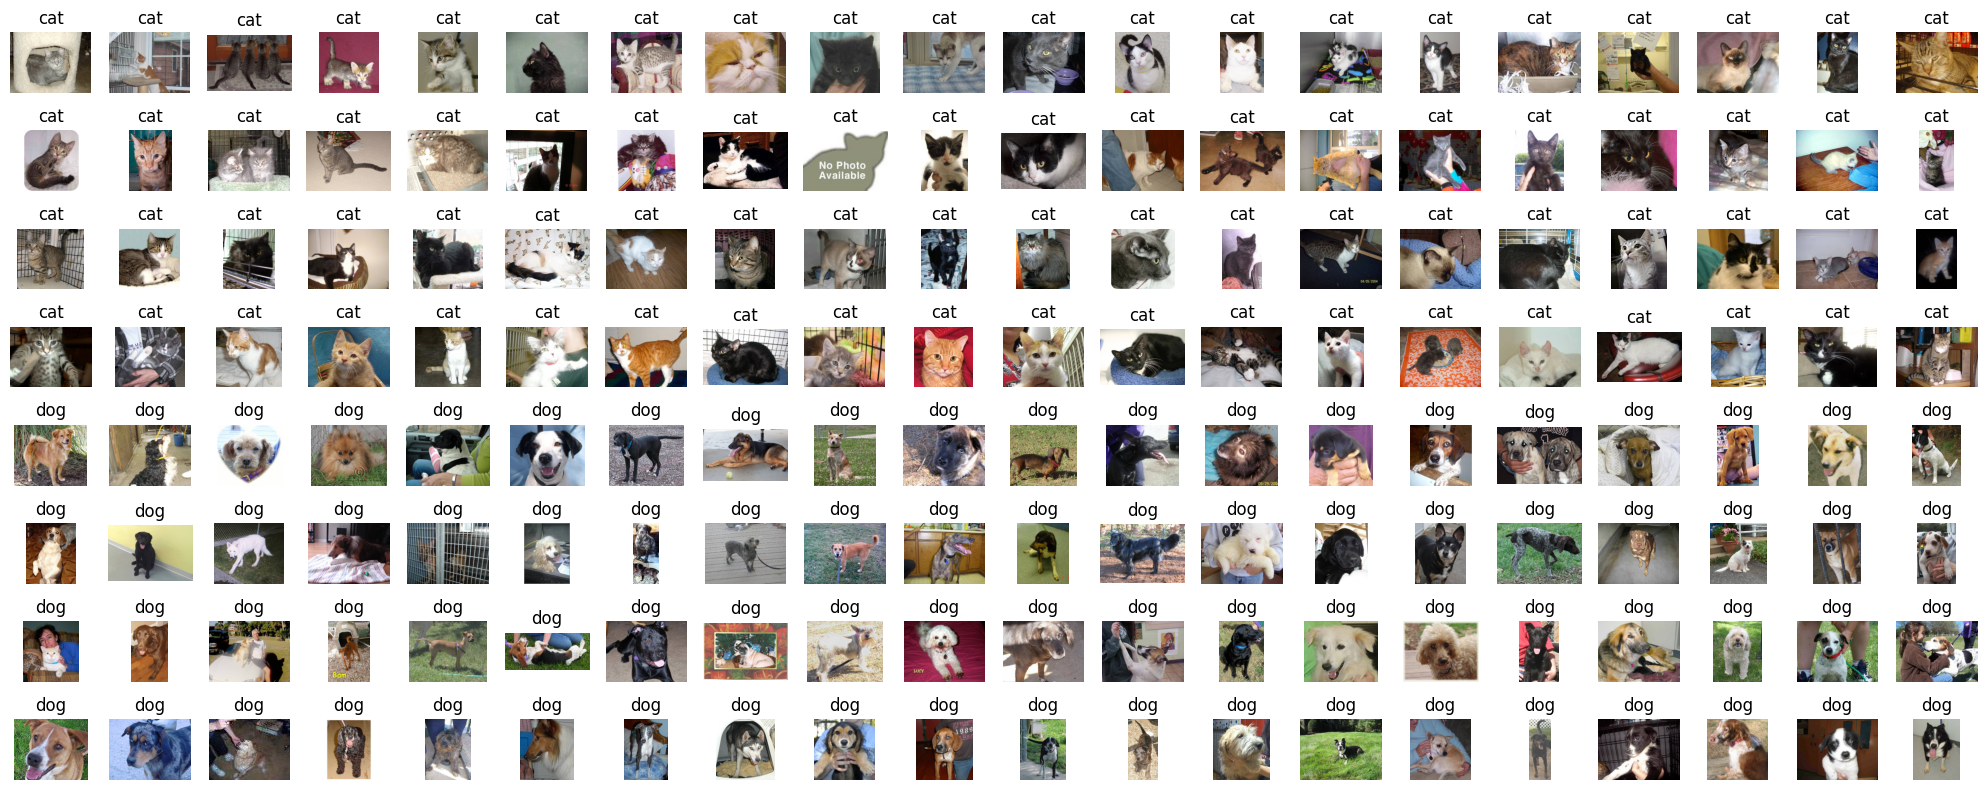

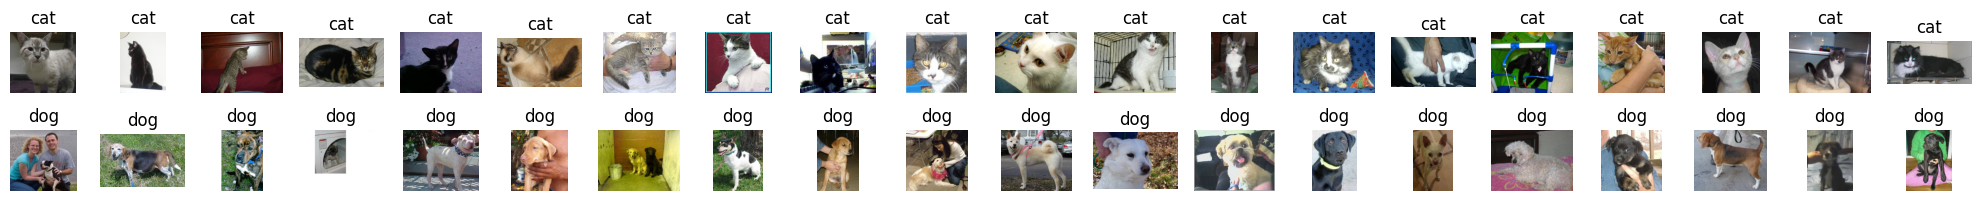

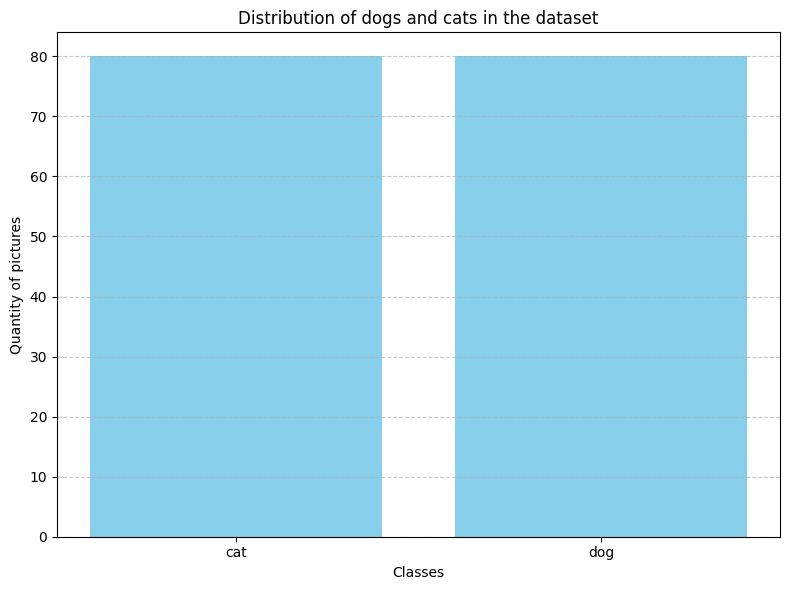

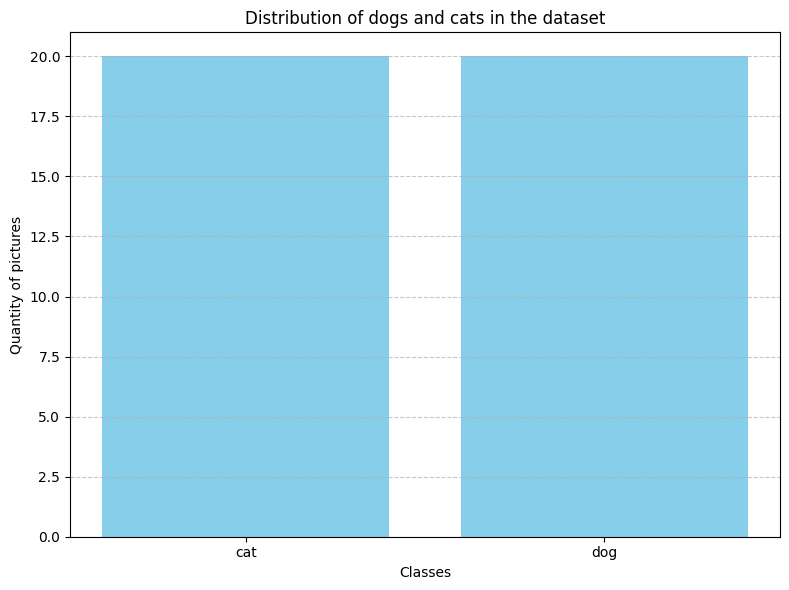

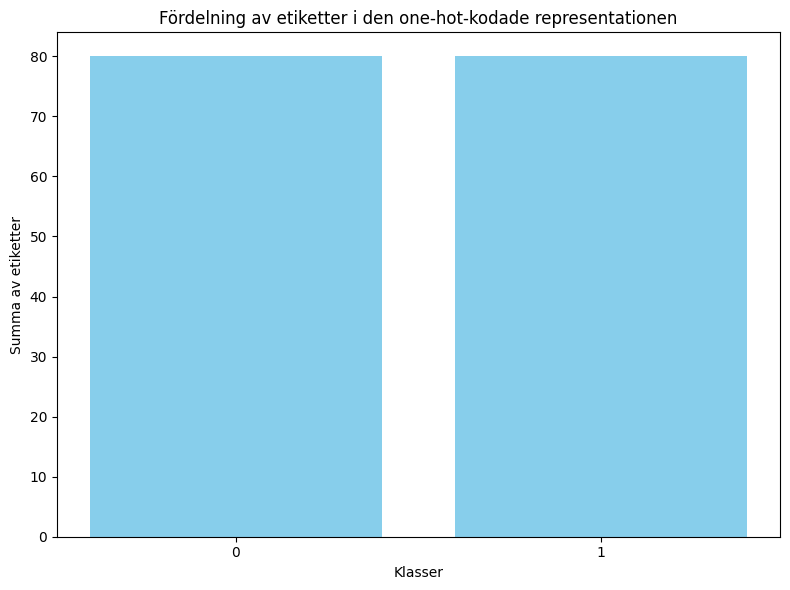

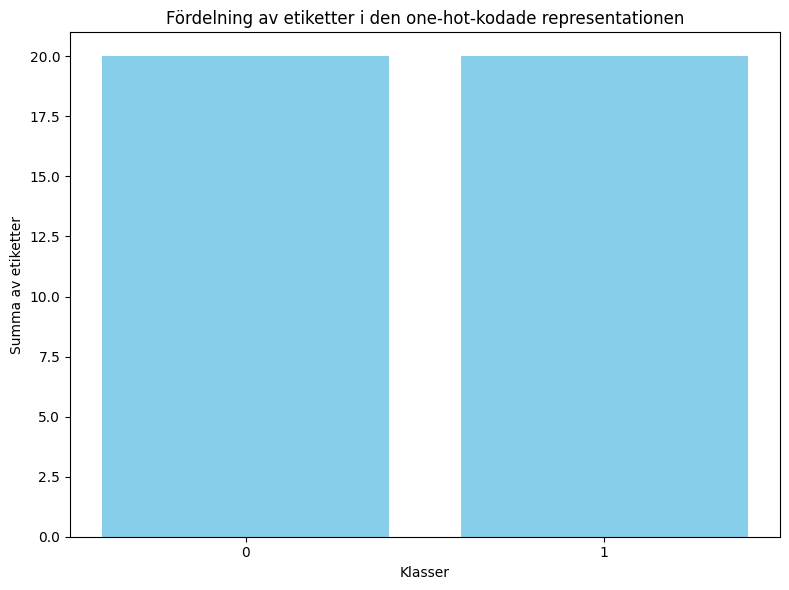

In [ ]:
# Verifying that the image labels match each other for the tiny train images
plt.figure(figsize=(20, 8))
for i, image in enumerate(tiny_train_images[:160]):  # First 160 images
    plt.subplot(8, 20, i + 1)
    plt.imshow(image)
    plt.title(tiny_train_labels[i])  
    plt.axis('off')
plt.tight_layout()  

plt.figure(figsize=(20, 8))
for i, image in enumerate(tiny_val_images[:40]):  # First 40 images
    plt.subplot(8, 20, i + 1)
    plt.imshow(image)
    plt.title(tiny_val_labels[i])  
    plt.axis('off')
plt.tight_layout()

# Verifying that the dataset is balanced
unique_labels, label_counts = np.unique(tiny_train_labels, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(unique_labels, label_counts, color='skyblue')
plt.xlabel('Classes') # Categories: dogs and cats
plt.ylabel('Quantity of pictures')
plt.title('Distribution of dogs and cats in the dataset')
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout()

unique_labels, label_counts = np.unique(tiny_val_labels, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(unique_labels, label_counts, color='skyblue')
plt.xlabel('Classes') # Categories: dogs and cats
plt.ylabel('Quantity of pictures')
plt.title('Distribution of dogs and cats in the dataset')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Verifying that the dataset is based on randomness
label_sums = np.sum(onehot_tiny_train_labels, axis=0)
plt.figure(figsize=(8, 6))
plt.bar(range(len(label_sums)), label_sums, color='skyblue')
plt.xlabel('Klasser')
plt.ylabel('Summa av etiketter')
plt.title('Fördelning av etiketter i den one-hot-kodade representationen')
plt.xticks(range(len(label_sums))) 
plt.tight_layout()

label_sums = np.sum(onehot_tiny_val_labels, axis=0)
plt.figure(figsize=(8, 6))
plt.bar(range(len(label_sums)), label_sums, color='skyblue')
plt.xlabel('Klasser')
plt.ylabel('Summa av etiketter')
plt.title('Fördelning av etiketter i den one-hot-kodade representationen')
plt.xticks(range(len(label_sums)))
plt.tight_layout()
plt.show()

# 1. A) Image processing 

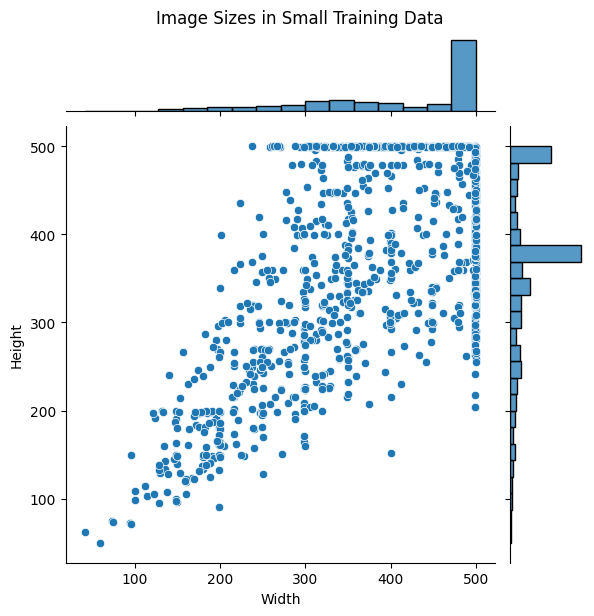

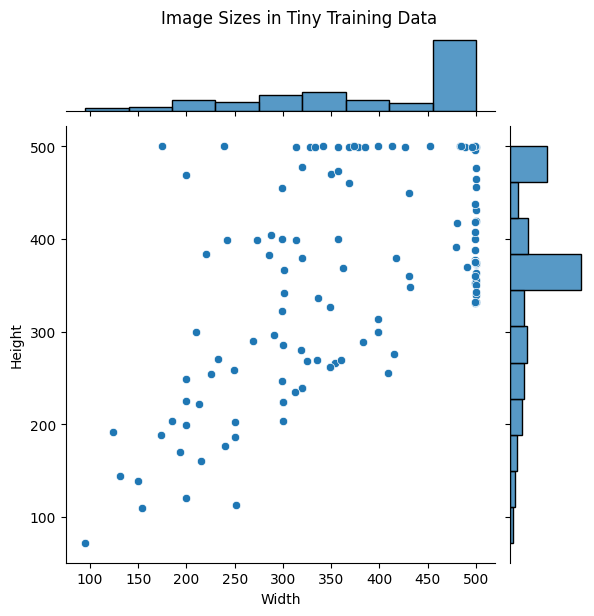

In [ ]:
def get_image_sizes_from_loaded_data(loaded_images):
    widths = []
    heights = []
    for img in loaded_images:
        width, height = img.size
        widths.append(width)
        heights.append(height)
    return widths, heights

# Reuse small_train_data to extract widths and heights
small_train_widths, small_train_heights = get_image_sizes_from_loaded_data(small_train_images)

# Reuse tiny_train_data to extract widths and heights
tiny_train_widths, tiny_train_heights = get_image_sizes_from_loaded_data(tiny_train_images)

# Create DataFrames
df_small_train = pd.DataFrame({'Width': small_train_widths, 'Height': small_train_heights})
df_tiny_train = pd.DataFrame({'Width': tiny_train_widths, 'Height': tiny_train_heights})

# Create jointplots 
joint_plot_small_train = sns.jointplot(x='Width', y='Height', data=df_small_train, kind='scatter')
joint_plot_small_train.figure.suptitle('Image Sizes in Small Training Data', y=1.02)

joint_plot_tiny_train = sns.jointplot(x='Width', y='Height', data=df_tiny_train, kind='scatter')
joint_plot_tiny_train.figure.suptitle('Image Sizes in Tiny Training Data', y=1.02)

plt.show()

# B) Choose a reasonable image size to resize training images to, analysis and arguments to why I choose that size

In [ ]:
# 1. The highest resolution is around 500x500 pixels in height and width, which could slow down processing during model training.
# 2. Choosing from the standard sizes commonly used in model training, 224x224 pixels seems to be an option to start from.
# 3. Deleting low resolution images might be a good option because images that are too low in quality could be redundant in model training.

# Answer: I choose the common standard size of 224x224 with the reason that it might be too slow to process and train the model with the highest image resolution, which is around 500x500 pixels.

# C) Resize images to 224x224 and convert them into a numpy array with the following structure: (samples, rows, columns, color channels)

In [ ]:
# Function for resizing images to 224x224
def resize_images(data):
    desired_image_size = (224, 224) # Desired resize values
    resized_images = []
    for img in data:
        resized_img = img.resize(desired_image_size, resample=Image.BICUBIC) # BICUBIC: Interpolation for sharp image resizing, help from LLM
        resized_images.append(resized_img)
    return resized_images

# Resize small and tiny training images
small_train_resize = resize_images(small_train_images) 
tiny_train_resize = resize_images(tiny_train_images)

# Resize small and tiny validation images
small_val_resize = resize_images(small_val_images)
tiny_val_resize = resize_images(tiny_val_images)

# Convert small, tiny training images and small, tiny validation images into a numpy array using the resized datasets with the structure: samples, rows, columns, color channels
converted_small_train_array = np.array(small_train_resize) # Small training images NumPy array
converted_tiny_train_array = np.array(tiny_train_resize) # Tiny training images NumPy array

converted_small_val_array = np.array(small_val_resize) # Small validation images NumPy array
converted_tiny_val_array = np.array(tiny_val_resize) # Tiny validation images NumPy array

# Convert encoded small and tiny training and validation image labels into a NumPy arrays
encoded_small_train_labels_array = np.array(encoded_small_train_labels)
encoded_tiny_train_labels_array = np.array(encoded_tiny_train_labels)
encoded_small_val_labels_array = np.array(encoded_small_val_labels)
encoded_tiny_val_labels_array = np.array(encoded_tiny_val_labels)

# Verify the form of the NumPy arrays
print("Form for converted_small_train_array:", converted_small_train_array.shape) # Small train images array
print("Form for converted_tiny_train_array:", converted_tiny_train_array.shape) # Tiny train images array

print("Form for converted_small_val_array:", converted_small_val_array.shape) # Small val images array
print("Form for converted_tiny_val_array:", converted_tiny_val_array.shape) # Tiny val images array

print("Form for small_train_labels_array:", encoded_small_train_labels_array.shape) # Small val labels
print("Form for tiny_train_labels_array:", encoded_tiny_train_labels_array.shape) # Tiny val labels

print("Form for small_val_labels_array:", encoded_small_val_labels_array.shape) # Small val labels
print("Form for tiny_val_labels_array:", encoded_tiny_val_labels_array.shape) # Tiny val labels 

Form for converted_small_train_array: (1600, 224, 224, 3)
Form for converted_tiny_train_array: (160, 224, 224, 3)
Form for converted_small_val_array: (400, 224, 224, 3)
Form for converted_tiny_val_array: (40, 224, 224, 3)
Form for small_train_labels_array: (1600,)
Form for tiny_train_labels_array: (160,)
Form for small_val_labels_array: (400,)
Form for tiny_val_labels_array: (40,)


# 2. A) Train models without augmentation

In [94]:
# Define CNN architecture for model, help from: https://www.tensorflow.org/tutorials/images/cnn and LLM
model = models.Sequential([
    layers.Conv2D(64, (5, 5), activation='relu', input_shape=(224, 224, 3)), # 32 kernels, size: 3x3, activation: relu, input_shape = 224x224 pixels, with color channels (Increased to 64, 5,5)
    layers.MaxPooling2D((2, 2)), # Stride: 2x2, size: 2x2
    layers.Conv2D(128, (5, 5), activation='relu'), # 64 kernels (Increased to 128, 5,5)
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'), # 128 kernels (Increased to 256)
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'), # 128 kernels (Increased to 256)
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.4), # rate: 0.3 (Increased to 0.4)
    layers.Dense(1024, activation='relu'),  # Fully connected layer - 512 nodes, activation: relu (Increased to 1024 units in dense layer)
    layers.Dense(1, activation='sigmoid')  # Output layer with 1 unit for binary classification, activation: sigmoid
])

# Compile CNN model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), #  Adam optimizer: popular optimization algorithm that adapts learning rates for each parameter (Reduced the learning rate might give the model a better learning curve)
              loss='binary_crossentropy', # binary cross-entropy: loss function for binary classification tasks where the output is either 0 or 1.
              metrics=['accuracy']) # Metrics: accuracy which calculates the proportion of correctly classified samples

# Generate a summary of the model
model.summary() 

c:\Users\Kevin\Desktop\AI-Kevin-Kinnunen-OPA23\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 220, 220, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 106, 106, 128)  │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 53, 53, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 51, 51, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 23, 23, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1024)           │    31,720,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,816,513 (125.19 MB)

 Trainable params: 32,816,513 (125.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.5104 - loss: 21.9422 - val_accuracy: 0.5025 - val_loss: 0.7708
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.5478 - loss: 0.7234 - val_accuracy: 0.6000 - val_loss: 0.6708
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.6344 - loss: 0.6443 - val_accuracy: 0.6475 - val_loss: 0.6438
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.6951 - loss: 0.5799 - val_accuracy: 0.6575 - val_loss: 0.6327
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.7326 - loss: 0.5215 - val_accuracy: 0.6425 - val_loss: 0.6790
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.7681 - loss: 0.4798 - val_accuracy: 0.6375 - val_loss: 0.7016
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.7909 - loss: 0.4443 - val_accuracy: 0.6350 - val_loss: 0.6750
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.8210 - loss: 0.3932 - val_accuracy: 0.6725 - val_loss

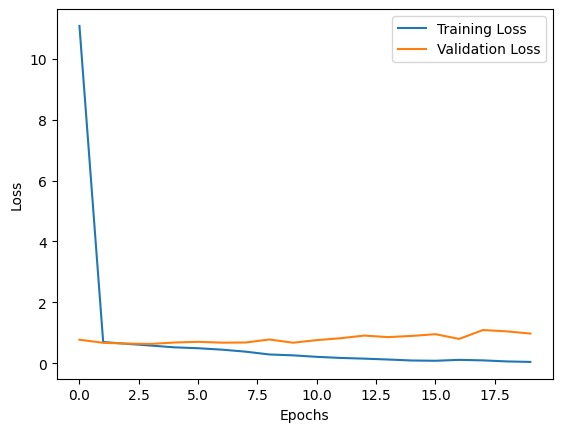

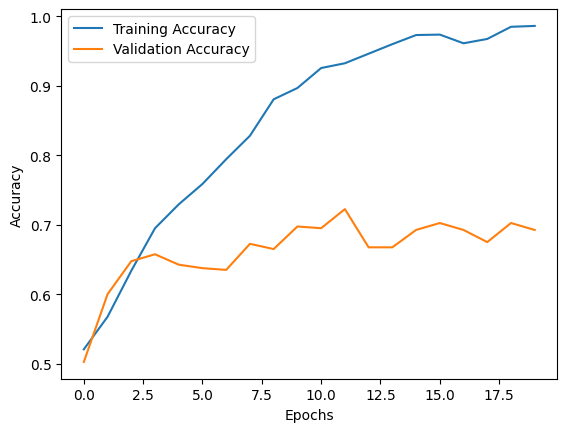

In [95]:
# Train the model on the small training and small validation images with their labels
small_history = model.fit(converted_small_train_array, encoded_small_train_labels_array, 
                    # Epochs of 10 is the number of complete passes through the entire training dataset
                    # Batch size 32 refers to the number of training image examples utilized in one iteration
                    epochs=20, batch_size=64, # Testing higher values for better prediction
                    validation_data=(converted_small_val_array, encoded_small_val_labels_array))

# Plot loss over epochs
plt.plot(small_history.history['loss'], label='Training Loss')
plt.plot(small_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Display legend and show plot
plt.legend()
plt.show()

# Plot accuracy over epochs
plt.plot(small_history.history['accuracy'], label='Training Accuracy')
plt.plot(small_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Display legend and show plot
plt.legend()
plt.show()

##### Results in the plotting were better after increasing epochs and batch_size. It might also be due to the increased values of kernels, nodes, dropout, lower learning rate for a better learning curve (Adam optimizer), and conv2d size. 24min to process tho

# C) Process the test data for evaluation, predict, and evaluate the CNN model predictions

In [98]:
# Small test data for evaluation
small_test_dir = paths["experiment_small_test"]

# Load test images
small_test_images = load_images(small_test_dir)

# Resize test images to same image size as training and validation images (224x224)
resize_small_images = resize_images(small_test_images)

# Convert the resized images to NumPy array
converted_small_test_array = np.array(resize_small_images)

# Predict the small model on the small test images
prediction_small = model.predict(converted_small_test_array)

# Display some predictions along with the filenames
for i in range(len(prediction_small)):
    filename = os.listdir(small_test_dir)[i]  # Extract filename directly from directory listing
    prediction = prediction_small[i][0]  # Get the prediction for the current image
    
    # Determine label based on prediction (thresholding)
    if prediction > 0.5:
        label = "Dog"
    else:
        label = "Cat"
    
    print(f"Image {filename}: Predicted label: {label} (Probability: {prediction:.2f})")

12/16 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step

KeyboardInterrupt: 

C:\Users\Kevin\AppData\Local\Temp\ipykernel_12760\2109497893.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction = float(predictions[i])


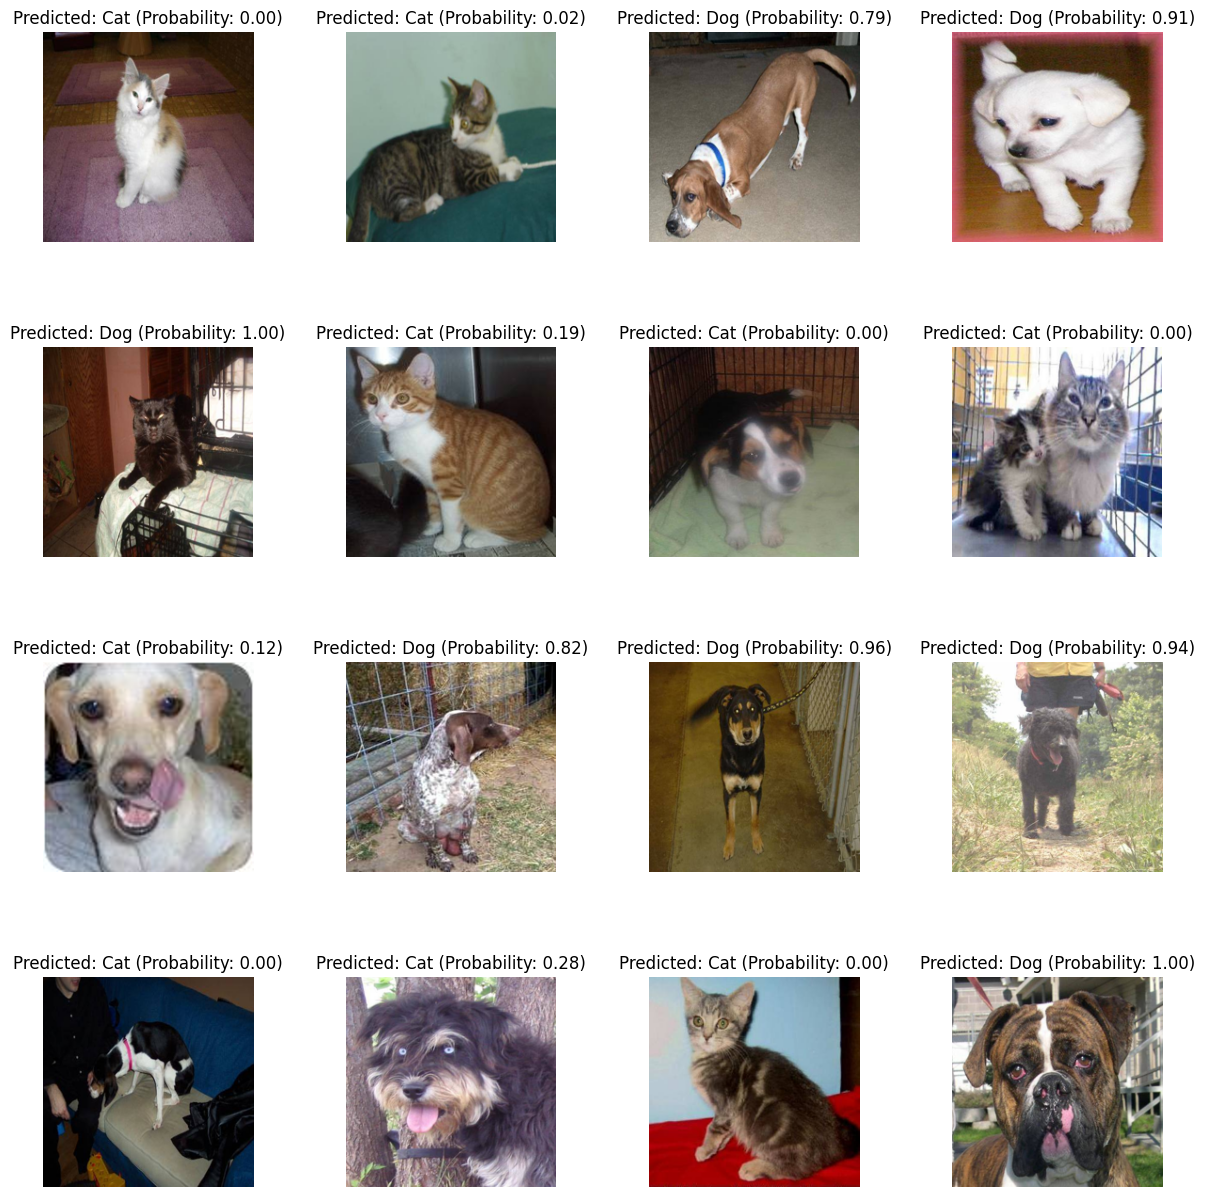

In [99]:
# Function to plot images with predictions
def plot_predictions(images, predictions, threshold=0.5):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
    fig.subplots_adjust(hspace=0.5)
    
    for i, ax in enumerate(axes.flat):
        # Plot image
        ax.imshow(images[i])
        ax.axis('off')
        
        # Convert prediction to a regular Python float
        prediction = float(predictions[i])
        
        # Determine label based on prediction
        if prediction > threshold:
            label = "Dog"
        else:
            label = "Cat"
        
        # Set title with predicted label and probability
        ax.set_title(f"Predicted: {label} (Probability: {prediction:.2f})")
    
    plt.show()

# Ensure only 16 images are passed to the function
num_images_to_display = 16
images_to_display = converted_small_test_array[:num_images_to_display]
predictions_to_display = prediction_small[:num_images_to_display]

# Plot predictions
plot_predictions(images_to_display, predictions_to_display)
